# King County - Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Normalization
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
from k_mean_cluster_util import k_mean_optimization

## Getting data ready
First We'll have some intuition on the data and set the "id" as index value. Also remove duplicate values.

In [2]:
df = pd.read_csv('./kc_house_data.csv')
df.set_index('id', inplace=True)
df = df[~df.index.duplicated(keep='first')]
df = df.drop(['zipcode', 'waterfront', 'date'], axis=1)
prices = df['price']
df = df.drop('price', axis=1)
df['price'] = prices
df.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  view  \
id                                                                     
7129300520         3       1.00         1180      5650     1.0     0   
6414100192         3       2.25         2570      7242     2.0     0   
5631500400         2       1.00          770     10000     1.0     0   
2487200875         4       3.00         1960      5000     1.0     0   
1954400510         3       2.00         1680      8080     1.0     0   

            condition  grade  sqft_above  sqft_basement  yr_built  \
id                                                                  
7129300520          3      7        1180              0      1955   
6414100192          3      7        2170            400      1951   
5631500400          3      6         770              0      1933   
2487200875          5      7        1050            910      1965   
1954400510          3      8        1680              0      1987   

            yr_renovated      lat     long  sqft_living15  sqft_lot15  \
id                                                                      
7129300520             0  47.5112 -122.257           1340        5650   
6414100192          1991  47.7210 -122.319           1690        7639   
5631500400             0  47.7379 -122.233           2720        8062   
2487200875             0  47.5208 -122.393           1360        5000   
1954400510             0  47.6168 -122.045           1800        7503   

               price  
id                    
7129300520  221900.0  
6414100192  538000.0  
5631500400  180000.0  
2487200875  604000.0  
1954400510  510000.0

From date which is an object, "str" in this dataset, we'll have to convert to date and take year and month which is important to our model.

In [3]:
# df['date'] = pd.to_datetime(df['date'])
# df['year'] = df['date'].dt.year
# df['month'] = df['date'].dt.month
# df = df.drop('date', axis=1)
# df.head()

Have an intuition on what columns contain null values and what their Dtypes are

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21436 entries, 7129300520 to 1523300157
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       21436 non-null  int64  
 1   bathrooms      21436 non-null  float64
 2   sqft_living    21436 non-null  int64  
 3   sqft_lot       21436 non-null  int64  
 4   floors         21436 non-null  float64
 5   view           21436 non-null  int64  
 6   condition      21436 non-null  int64  
 7   grade          21436 non-null  int64  
 8   sqft_above     21436 non-null  int64  
 9   sqft_basement  21436 non-null  int64  
 10  yr_built       21436 non-null  int64  
 11  yr_renovated   21436 non-null  int64  
 12  lat            21436 non-null  float64
 13  long           21436 non-null  float64
 14  sqft_living15  21436 non-null  int64  
 15  sqft_lot15     21436 non-null  int64  
 16  price          21436 non-null  float64
dtypes: float64(5), int64(12)
memory usag

In [5]:
df.describe().T

count           mean            std         min          25%  \
bedrooms       21436.0       3.371571       0.929205      0.0000       3.0000   
bathrooms      21436.0       2.117349       0.769913      0.0000       1.7500   
sqft_living    21436.0    2082.704936     919.146469    290.0000    1430.0000   
sqft_lot       21436.0   15135.637852   41538.620606    520.0000    5040.0000   
floors         21436.0       1.496198       0.540388      1.0000       1.0000   
view           21436.0       0.235118       0.767092      0.0000       0.0000   
condition      21436.0       3.410384       0.650235      1.0000       3.0000   
grade          21436.0       7.661737       1.174256      1.0000       7.0000   
sqft_above     21436.0    1790.960440     829.026491    290.0000    1200.0000   
sqft_basement  21436.0     291.744495     442.781983      0.0000       0.0000   
yr_built       21436.0    1971.098433      29.385277   1900.0000    1952.0000   
yr_renovated   21436.0      84.729800     402.431012      0.0000       0.0000   
lat            21436.0      47.560156       0.138601     47.1559      47.4711   
long           21436.0    -122.213697       0.140896   -122.5190    -122.3280   
sqft_living15  21436.0    1988.314378     685.699093    399.0000    1490.0000   
sqft_lot15     21436.0   12785.961280   27375.467469    651.0000    5100.0000   
price          21436.0  540529.287180  367689.296471  75000.0000  322150.0000   

                      50%         75%           max  
bedrooms            3.000       4.000  3.300000e+01  
bathrooms           2.250       2.500  8.000000e+00  
sqft_living      1920.000    2550.000  1.354000e+04  
sqft_lot         7614.000   10696.250  1.651359e+06  
floors              1.500       2.000  3.500000e+00  
view                0.000       0.000  4.000000e+00  
condition           3.000       4.000  5.000000e+00  
grade               7.000       8.000  1.300000e+01  
sqft_above       1560.000    2220.000  9.410000e+03  
sqft_basement       0.000     560.000  4.820000e+03  
yr_built         1975.000    1997.000  2.015000e+03  
yr_renovated        0.000       0.000  2.015000e+03  
lat                47.572      47.678  4.777760e+01  
long             -122.230    -122.124 -1.213150e+02  
sqft_living15    1840.000    2370.000  6.210000e+03  
sqft_lot15       7620.000   10087.250  8.712000e+05  
price          450000.000  645000.000  7.700000e+06

In [6]:
(df == 0).sum()

bedrooms            13
bathrooms           10
sqft_living          0
sqft_lot             0
floors               0
view             19320
condition            0
grade                0
sqft_above           0
sqft_basement    13015
yr_built             0
yr_renovated     20526
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
price                0
dtype: int64

Correlation of two values gives a great insight on what features impact the values of each other

In [7]:
df.corr()

bedrooms  bathrooms  sqft_living  sqft_lot    floors      view  \
bedrooms       1.000000   0.516772     0.577512  0.031719  0.175207  0.079542   
bathrooms      0.516772   1.000000     0.754422  0.087143  0.499863  0.186684   
sqft_living    0.577512   0.754422     1.000000  0.171957  0.352867  0.283753   
sqft_lot       0.031719   0.087143     0.171957  1.000000 -0.005950  0.075012   
floors         0.175207   0.499863     0.352867 -0.005950  1.000000  0.028211   
view           0.079542   0.186684     0.283753  0.075012  0.028211  1.000000   
condition      0.027896  -0.127839    -0.060973 -0.009298 -0.266543  0.045051   
grade          0.358396   0.664727     0.762402  0.112541  0.457475  0.249890   
sqft_above     0.478441   0.684994     0.876683  0.182581  0.522648  0.166930   
sqft_basement  0.303035   0.283539     0.434419  0.015107 -0.246066  0.276482   
yr_built       0.153745   0.505092     0.316544  0.052447  0.489062 -0.055153   
yr_renovated   0.018435   0.051101     0.055084  0.007636  0.005626  0.103633   
lat           -0.010228   0.023444     0.051118 -0.085992  0.049279  0.005671   
long           0.129836   0.221935     0.239214  0.229555  0.124285 -0.079720   
sqft_living15  0.393161   0.568194     0.756205  0.143650  0.278854  0.279077   
sqft_lot15     0.029117   0.086627     0.182775  0.718097 -0.011917  0.072867   
price          0.309007   0.525453     0.701993  0.088895  0.256278  0.396933   

               condition     grade  sqft_above  sqft_basement  yr_built  \
bedrooms        0.027896  0.358396    0.478441       0.303035  0.153745   
bathrooms      -0.127839  0.664727    0.684994       0.283539  0.505092   
sqft_living    -0.060973  0.762402    0.876683       0.434419  0.316544   
sqft_lot       -0.009298  0.112541    0.182581       0.015107  0.052447   
floors         -0.266543  0.457475    0.522648      -0.246066  0.489062   
view            0.045051  0.249890    0.166930       0.276482 -0.055153   
condition       1.000000 -0.148248   -0.160782       0.174463 -0.364947   
grade          -0.148248  1.000000    0.756068       0.167032  0.445329   
sqft_above     -0.160782  0.756068    1.000000      -0.052456  0.422838   
sqft_basement   0.174463  0.167032   -0.052456       1.000000 -0.134590   
yr_built       -0.364947  0.445329    0.422838      -0.134590  1.000000   
yr_renovated   -0.061136  0.014357    0.022666       0.071909 -0.225697   
lat            -0.015402  0.113332   -0.001652       0.109208 -0.148606   
long           -0.107780  0.196572    0.343115      -0.145846  0.408531   
sqft_living15  -0.095002  0.712507    0.731992       0.199247  0.324568   
sqft_lot15     -0.003731  0.118313    0.193413       0.017283  0.070307   
price           0.035089  0.667496    0.605495       0.323552  0.052967   

               yr_renovated       lat      long  sqft_living15  sqft_lot15  \
bedrooms           0.018435 -0.010228  0.129836       0.393161    0.029117   
bathrooms          0.051101  0.023444  0.221935       0.568194    0.086627   
sqft_living        0.055084  0.051118  0.239214       0.756205    0.182775   
sqft_lot           0.007636 -0.085992  0.229555       0.143650    0.718097   
floors             0.005626  0.049279  0.124285       0.278854   -0.011917   
view               0.103633  0.005671 -0.079720       0.279077    0.072867   
condition         -0.061136 -0.015402 -0.107780      -0.095002   -0.003731   
grade              0.014357  0.113332  0.196572       0.712507    0.118313   
sqft_above         0.022666 -0.001652  0.343115       0.731992    0.193413   
sqft_basement      0.071909  0.109208 -0.145846       0.199247    0.017283   
yr_built          -0.225697 -0.148606  0.408531       0.324568    0.070307   
yr_renovated       1.000000  0.029206 -0.068736      -0.002677    0.007870   
lat                0.029206  1.000000 -0.136369       0.047668   -0.086505   
long              -0.068736 -0.136369  1.000000       0.333652    0.254280   
sqft_living15     -0.002677  0.0476

<AxesSubplot:>

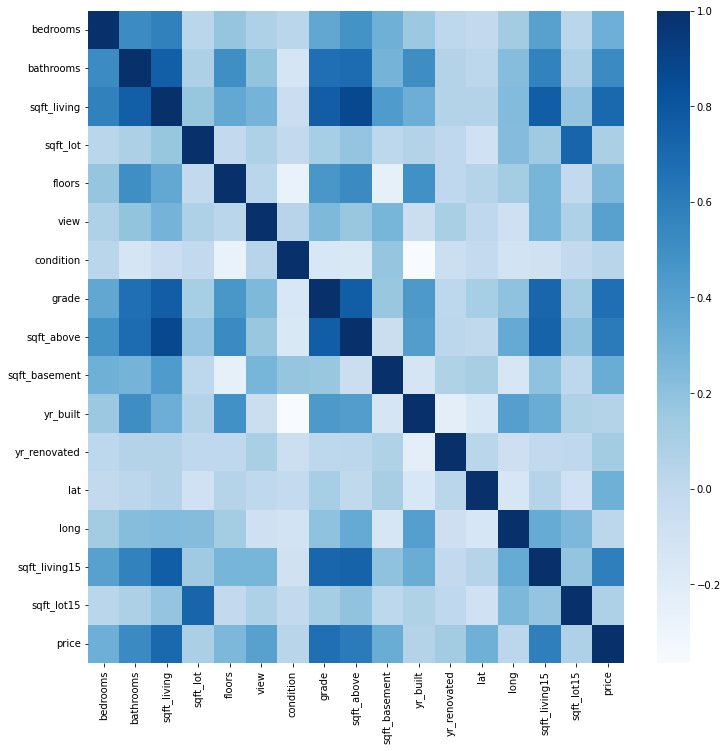

In [8]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), cmap='Blues')

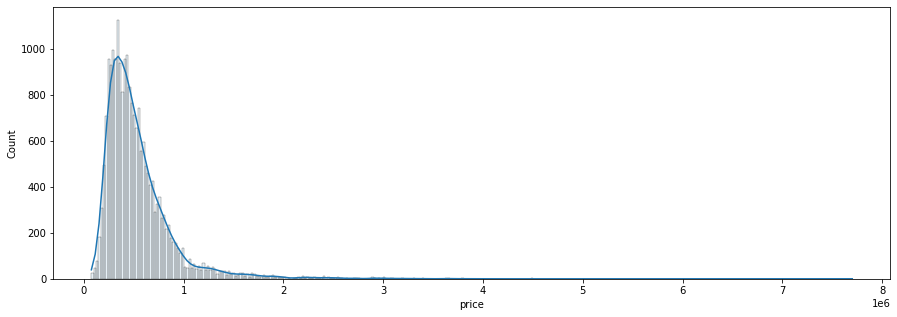

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='price', ax=ax, kde=True, alpha=0.1);

<AxesSubplot:xlabel='price'>

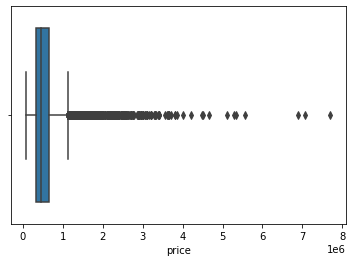

In [10]:
sns.boxplot(data=df, x='price')

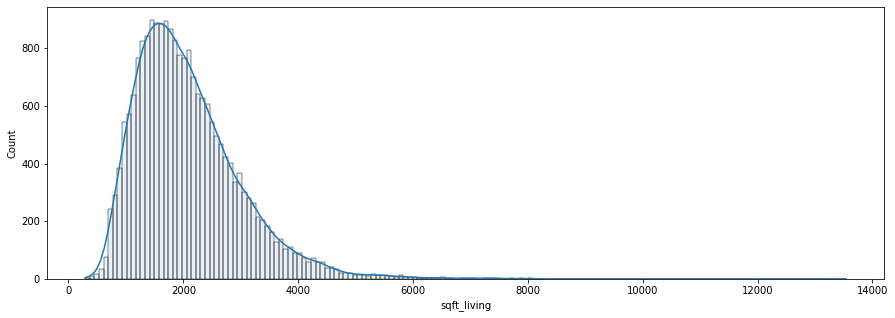

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living', ax=ax, kde=True, alpha=0.1);

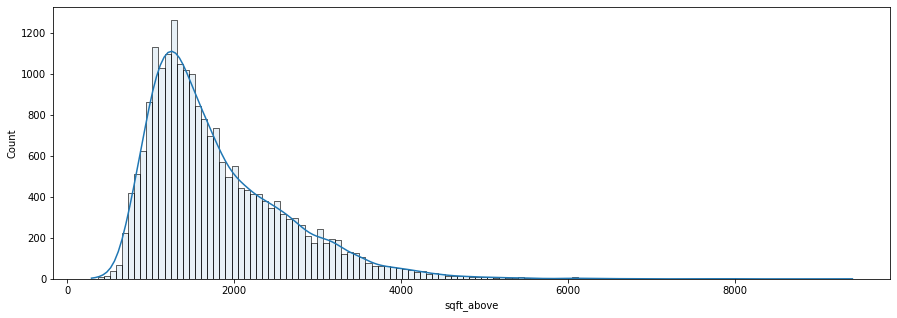

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_above', ax=ax, kde=True, alpha=0.1);

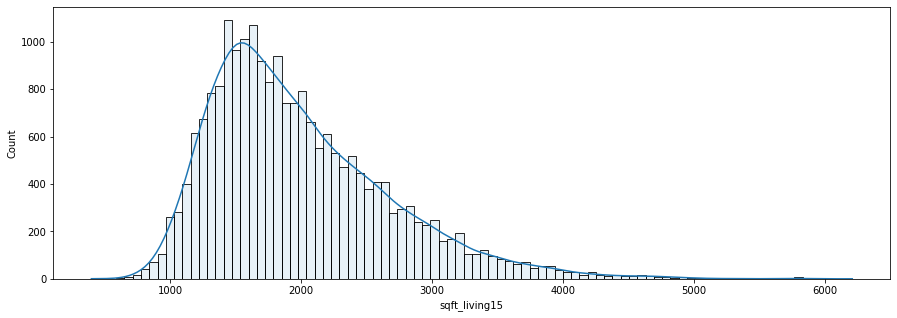

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living15', ax=ax, kde=True, alpha=0.1);

<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

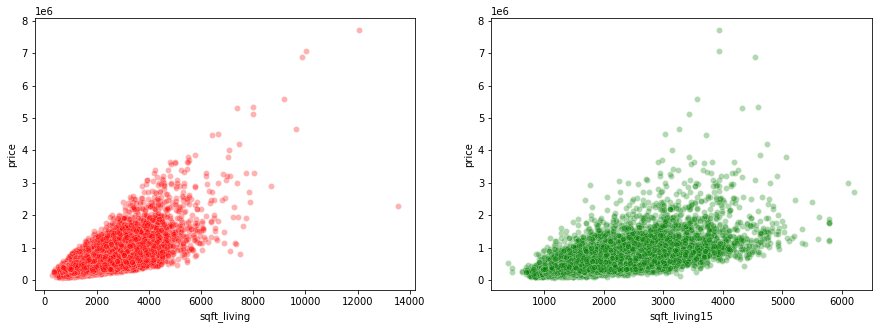

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=df, x='sqft_living', y='price', ax=ax[0], alpha=0.3, color='red')
sns.scatterplot(data=df, x='sqft_living15', y='price', ax=ax[1], alpha=0.3, color='green')

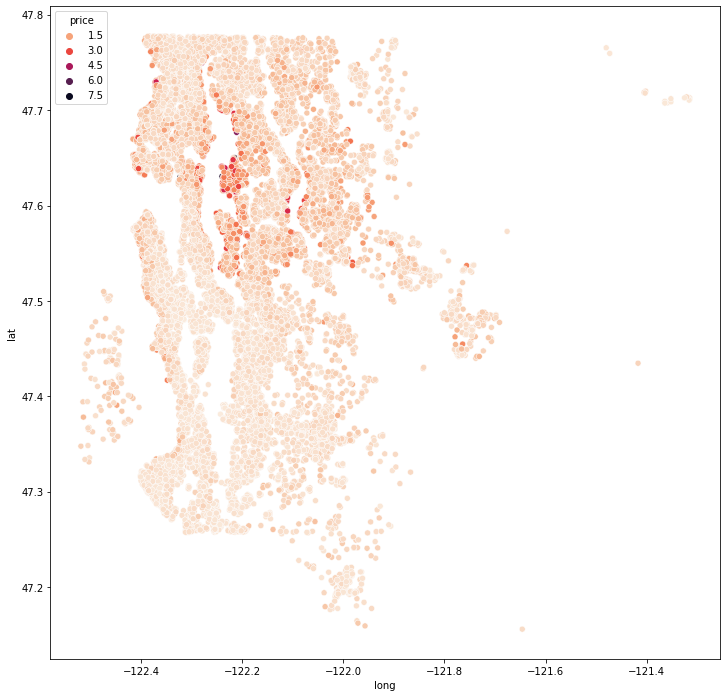

In [15]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x='long', y='lat', hue='price', palette='rocket_r',);

### Should we remove outliers?
For housing prices, a house could have been sold for a value less than what it worths. Or the house could've been sold more than what it worths. According to the red graph, some house with 13.5k sqft_living has been sold for about 2m dollars but some other house with about 12k sqft_living has been sold for about 7.5m dollars. This case could be seen as an outlier but there are other factors that have impact on the price.

In [16]:
df[df['sqft_living'] > 12000].T

id               6762700020    1225069038
bedrooms       6.000000e+00  7.000000e+00
bathrooms      8.000000e+00  8.000000e+00
sqft_living    1.205000e+04  1.354000e+04
sqft_lot       2.760000e+04  3.077520e+05
floors         2.500000e+00  3.000000e+00
view           3.000000e+00  4.000000e+00
condition      4.000000e+00  3.000000e+00
grade          1.300000e+01  1.200000e+01
sqft_above     8.570000e+03  9.410000e+03
sqft_basement  3.480000e+03  4.130000e+03
yr_built       1.910000e+03  1.999000e+03
yr_renovated   1.987000e+03  0.000000e+00
lat            4.762980e+01  4.766750e+01
long          -1.223230e+02 -1.219860e+02
sqft_living15  3.940000e+03  4.850000e+03
sqft_lot15     8.800000e+03  2.178000e+05
price          7.700000e+06  2.280000e+06

Two houses are somewhat the same and in the same area according to their lat and long. <br>
- More expensive one is older than the new one
- More expensive one's grade is greater than the other by 1 values
- sqft_lot15 is very large compared to the other one
- In 1987, the expensive house has been renovated but the other one hasn't been renovated
<br>
Other than these, the other house is better in every aspect. So why it is less expensive or not at all expensive? <br>
I'd say the first one is expensive because it is near the lake.

## Removing outliers

In [17]:
def remove_outliers(df, columns='all'):
    columns = df.columns if columns == 'all' else columns
    for c in columns:
        df = remove_columns_outlier(df, c)
    return df

def remove_columns_outlier(df, column):
    column = df[column]
    column_norm = (column - np.mean(column)) / np.std(column)
    column_norm = column_norm[~((column_norm >= 3) | (column_norm <= -3))]
    return df.loc[df.index[df.index.value_counts() == 1]]

def remove_outliers_per(df, column, per_column):
    fraction = column / per_column
    frac_norm = (fraction - np.mean(fraction)) / np.std(fraction)
    frac_norm = frac_norm[~((frac_norm >= 3) | (frac_norm <= -3))]
    return df.loc[list(frac_norm.index)]

def percentage_from_right(df, column, from_value):
    per = df[df[column] > from_value].size / df.size
    per = per * 100
    return per

def percentage_from_left(df, column, from_value):
    per = df[df[column] < from_value].size / df.size
    per = per * 100
    return per
    
def drop_tail_right(df, column, from_value, max_percentage=5):
    per = percentage_from_right(df, column, from_value)
    if per > max_percentage: raise ValueError(f'Percentage ({per:.2f}%) greater than {max_percentage:.2f}%')
    return df[df[column] < from_value]

def drop_tail_left(df, column, from_value, max_percentage=5):
    per = percentage_from_left(df, column, from_value)
    if per > max_percentage: raise ValueError(f'Percentage ({per:.2f}%) greater than {max_percentage:.2f}%')
    return df[df[column] > from_value]


def remove_outliers_IQR(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3 - q1
    res = drop_tail_right(df, column, q3 + 1.5 * IQR, 100)
    res = drop_tail_left(res, column, q1 - 1.5 * IQR, 100)
    per = percentage_from_right(df, column, q3 + 1.5 * IQR) + percentage_from_left(df, column, q1 - 1.5 * IQR)
    print(f'dropping {per:.2f}% data')
    return res

In [18]:
#df = remove_outliers(df, ['price'])
#df = remove_outliers_per(df, df['price'], df['sqft_living'])
#df = remove_outliers_per(df, df['price'], df['sqft_above'])
#df = remove_outliers_per(df, df['price'], df['sqft_living15'])

#df = drop_tail_right(df, 'price', 969000, 9)
#df = drop_tail_right(df, 'sqft_living', 3850, 3)
#df = drop_tail_right(df, 'sqft_living15', 3500, 3)
#df = drop_tail_left(df, 'grade', 5, 5)
#df = drop_tail_right(df, 'grade', 11, 5)

df = remove_outliers_IQR(df, 'price')
#df = remove_outliers_IQR(df, 'sqft_living')
#df = df.drop('sqft_above', axis=1)

dropping 5.31% data


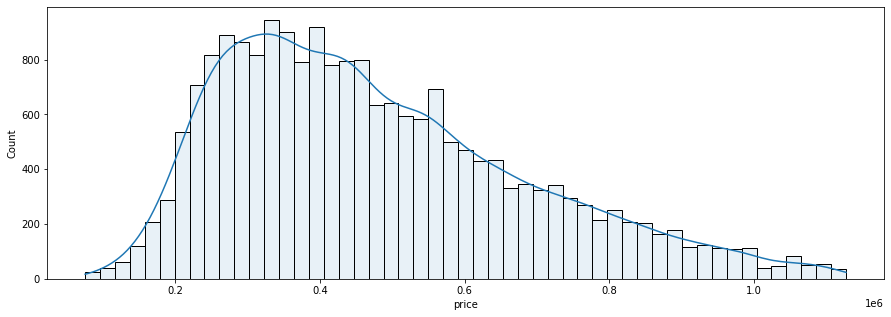

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='price', ax=ax, kde=True, alpha=0.1);

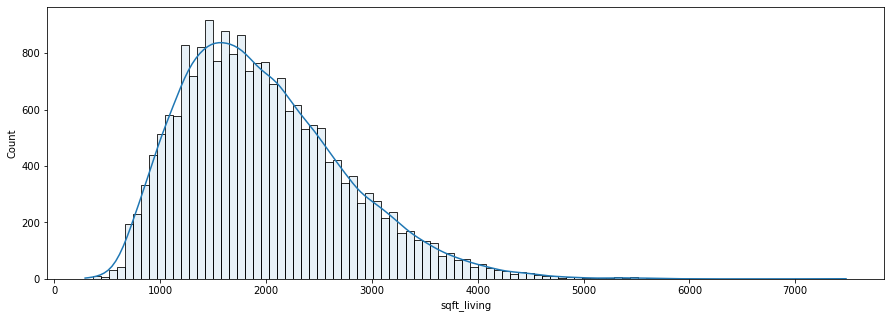

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living', ax=ax, kde=True, alpha=0.1);

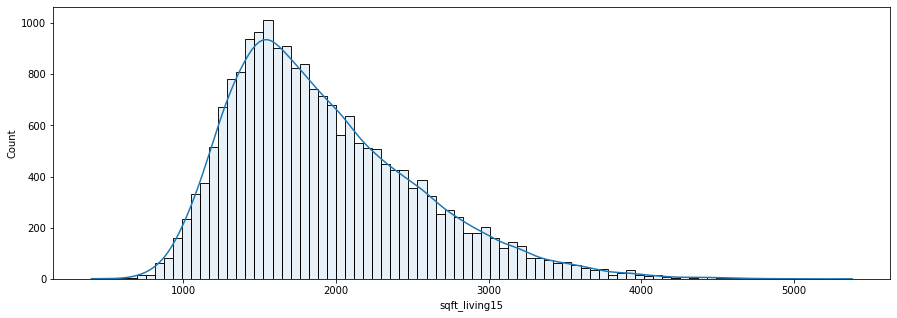

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.histplot(data=df, x='sqft_living15', ax=ax, kde=True, alpha=0.1);

<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

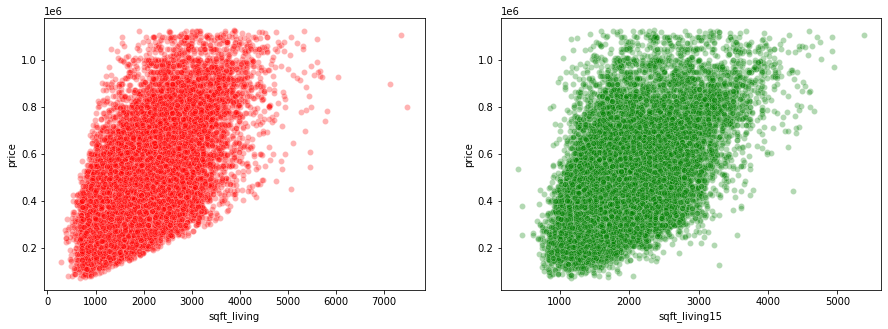

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=df, x='sqft_living', y='price', ax=ax[0], alpha=0.3, color='red')
sns.scatterplot(data=df, x='sqft_living15', y='price', ax=ax[1], alpha=0.3, color='green')

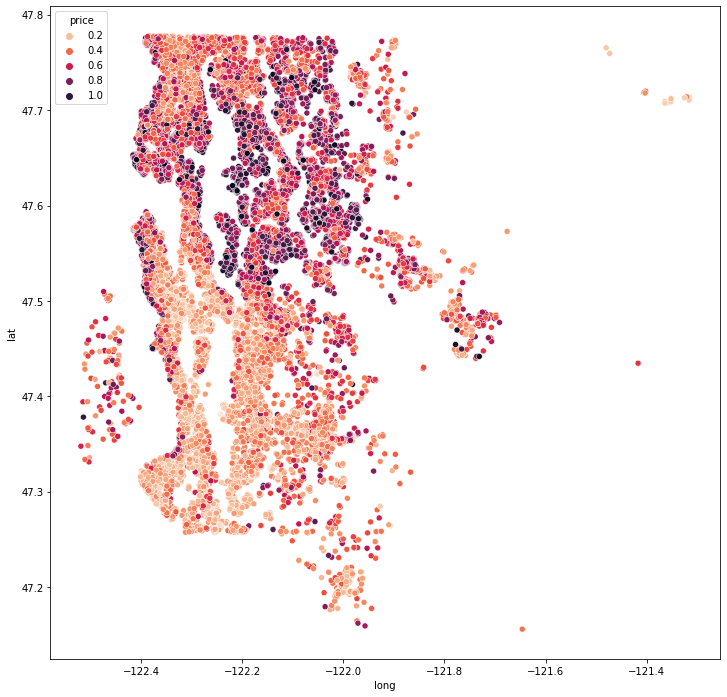

In [23]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x='long', y='lat', hue='price', palette='rocket_r',);

As it seems some regions here, have expensive houses, So we'll try to cluster each region.<br>
We'll use "lat" and "long" and "price" to cluster each using K_mean clustering algorithm.

In [24]:
selected = df[['lat', 'long', 'price']]
ids = selected.index.values
selected = selected.values
selected.shape

(20297, 3)

In [25]:
centeroids, idx = k_mean_optimization(selected, 10, 50, 20)

Iteration 1/20
Distortion: 702171571.8944975
Iteration 2/20
Distortion: 695823874.9965652
Iteration 3/20
Distortion: 778120647.4773111
Iteration 4/20
Distortion: 715581725.1832263
Iteration 5/20
Distortion: 696396359.1900002
Iteration 6/20
Distortion: 696396359.1900002
Iteration 7/20
Distortion: 796921709.1803733
Iteration 8/20
Distortion: 771022583.6387728
Iteration 9/20
Distortion: 737911740.0746601
Iteration 10/20
Distortion: 696839588.6763926
Iteration 11/20
Distortion: 802415123.6907015
Iteration 12/20
Distortion: 788035028.5785488
Iteration 13/20
Distortion: 696839588.6763926
Iteration 14/20
Distortion: 766538168.6235362
Iteration 15/20
Distortion: 778002813.5754619
Iteration 16/20
Distortion: 796977615.1541004
Iteration 17/20
Distortion: 796977615.1541004
Iteration 18/20
Distortion: 703967496.8748016
Iteration 19/20
Distortion: 783608156.9942273
Iteration 20/20
Distortion: 715520062.4571521

Distortion 695823874.9965652 is chosen!


In [26]:
selected = np.c_[ids, selected, idx]
selected = pd.DataFrame(selected, columns=['id', 'lat', 'long', 'price', 'cluster'])
selected

id      lat     long     price  cluster
0      7.129301e+09  47.5112 -122.257  221900.0      8.0
1      6.414100e+09  47.7210 -122.319  538000.0      0.0
2      5.631500e+09  47.7379 -122.233  180000.0      8.0
3      2.487201e+09  47.5208 -122.393  604000.0      2.0
4      1.954401e+09  47.6168 -122.045  510000.0      0.0
...             ...      ...      ...       ...      ...
20292  2.630000e+08  47.6993 -122.346  360000.0      4.0
20293  6.600060e+09  47.5107 -122.362  400000.0      5.0
20294  1.523300e+09  47.5944 -122.299  402101.0      5.0
20295  2.913101e+08  47.5345 -122.069  400000.0      5.0
20296  1.523300e+09  47.5941 -122.299  325000.0      4.0

[20297 rows x 5 columns]

In [27]:
selected.set_index('id', inplace=True)
selected

lat     long     price  cluster
id                                               
7.129301e+09  47.5112 -122.257  221900.0      8.0
6.414100e+09  47.7210 -122.319  538000.0      0.0
5.631500e+09  47.7379 -122.233  180000.0      8.0
2.487201e+09  47.5208 -122.393  604000.0      2.0
1.954401e+09  47.6168 -122.045  510000.0      0.0
...               ...      ...       ...      ...
2.630000e+08  47.6993 -122.346  360000.0      4.0
6.600060e+09  47.5107 -122.362  400000.0      5.0
1.523300e+09  47.5944 -122.299  402101.0      5.0
2.913101e+08  47.5345 -122.069  400000.0      5.0
1.523300e+09  47.5941 -122.299  325000.0      4.0

[20297 rows x 4 columns]

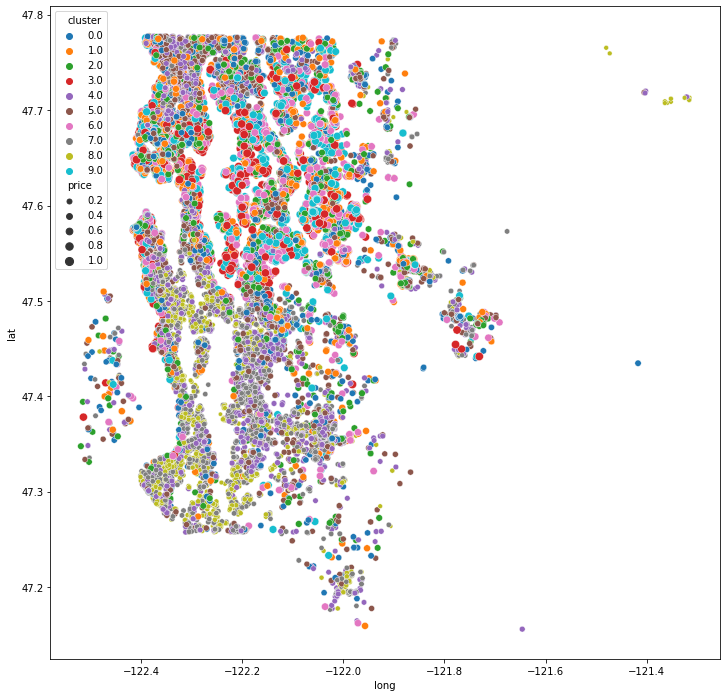

In [28]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=selected, x='long', y='lat', hue='cluster', palette='tab10', size='price');

In [29]:
clusters = pd.get_dummies(data=selected.cluster, drop_first=True, prefix='cluster')
df = pd.concat([df, clusters], axis=1)

In [30]:
df = df.drop(['sqft_living15', 'sqft_lot15', 'sqft_above'], axis=1)

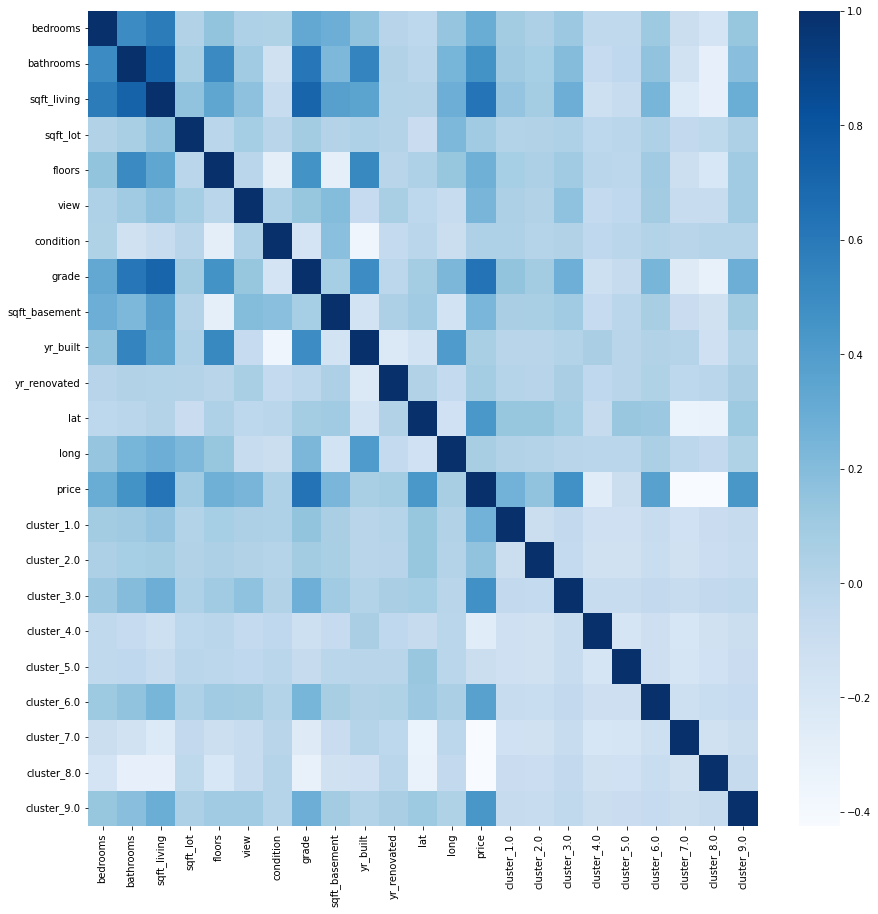

In [31]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), cmap='Blues');

In [32]:
df.describe().T

count           mean            std         min          25%  \
bedrooms       20297.0       3.330246       0.911846      0.0000       3.0000   
bathrooms      20297.0       2.054084       0.711399      0.0000       1.5000   
sqft_living    20297.0    1978.235158     775.491728    290.0000    1400.0000   
sqft_lot       20297.0   14646.335173   40247.208902    520.0000    5000.0000   
floors         20297.0       1.477854       0.537484      1.0000       1.0000   
view           20297.0       0.173622       0.642417      0.0000       0.0000   
condition      20297.0       3.407499       0.646790      1.0000       3.0000   
grade          20297.0       7.535498       1.038258      1.0000       7.0000   
sqft_basement  20297.0     267.498596     409.367450      0.0000       0.0000   
yr_built       20297.0    1970.910874      29.168739   1900.0000    1952.0000   
yr_renovated   20297.0      74.916539     379.343170      0.0000       0.0000   
lat            20297.0      47.556983       0.141081     47.1559      47.4604   
long           20297.0    -122.213026       0.142481   -122.5190    -122.3300   
price          20297.0  477262.096369  208498.449648  75000.0000  315000.0000   
cluster_1.0    20297.0       0.082426       0.275019      0.0000       0.0000   
cluster_2.0    20297.0       0.096763       0.295642      0.0000       0.0000   
cluster_3.0    20297.0       0.031630       0.175018      0.0000       0.0000   
cluster_4.0    20297.0       0.157412       0.364198      0.0000       0.0000   
cluster_5.0    20297.0       0.146524       0.353640      0.0000       0.0000   
cluster_6.0    20297.0       0.069715       0.254672      0.0000       0.0000   
cluster_7.0    20297.0       0.161206       0.367730      0.0000       0.0000   
cluster_8.0    20297.0       0.090605       0.287053      0.0000       0.0000   
cluster_9.0    20297.0       0.050697       0.219384      0.0000       0.0000   

                       50%          75%           max  
bedrooms            3.0000       4.0000  3.300000e+01  
bathrooms           2.0000       2.5000  7.500000e+00  
sqft_living      1860.0000    2440.0000  7.480000e+03  
sqft_lot         7500.0000   10321.0000  1.651359e+06  
floors              1.0000       2.0000  3.500000e+00  
view                0.0000       0.0000  4.000000e+00  
condition           3.0000       4.0000  5.000000e+00  
grade               7.0000       8.0000  1.200000e+01  
sqft_basement       0.0000     510.0000  2.720000e+03  
yr_built         1975.0000    1996.0000  2.015000e+03  
yr_renovated        0.0000       0.0000  2.015000e+03  
lat                47.5671      47.6798  4.777760e+01  
long             -122.2310    -122.1220 -1.213150e+02  
price          437850.0000  601000.0000  1.127500e+06  
cluster_1.0         0.0000       0.0000  1.000000e+00  
cluster_2.0         0.0000       0.0000  1.000000e+00  
cluster_3.0         0.0000       0.0000  1.000000e+00  
cluster_4.0         0.0000       0.0000  1.000000e+00  
cluster_5.0         0.0000       0.0000  1.000000e+00  
cluster_6.0         0.0000       0.0000  1.000000e+00  
cluster_7.0         0.0000       0.0000  1.000000e+00  
cluster_8.0         0.0000       0.0000  1.000000e+00  
cluster_9.0         0.0000       0.0000  1.000000e+00

## Getting Data ready for trainning

In [33]:
X_train = df.drop(['price'], axis=1).values
y_train = df['price'].values

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.8, random_state=123)
X_test, X_cv, y_test, y_cv = train_test_split(X_test, y_test, test_size=0.5, random_state=10)

In [34]:
print(f'X_train shape is {X_train.shape} and y_train shape is {y_train.shape}')
print(f'y_cv shape is {X_cv.shape} and y_cv shape is {y_cv.shape}')
print(f'X_test shape is {X_test.shape} and y_test shape is {y_test.shape}')

X_train shape is (16237, 22) and y_train shape is (16237,)
y_cv shape is (2030, 22) and y_cv shape is (2030,)
X_test shape is (2030, 22) and y_test shape is (2030,)


### Normalize the data

In [35]:
norm = Normalization()
norm.adapt(X_train)
Xn_train = norm(X_train)
Xn_cv = norm(X_cv)
Xn_test = norm(X_test)

## Training

In [36]:
model = SGDRegressor(max_iter=100000, verbose=True, learning_rate='adaptive')
model = model.fit(Xn_train, y_train)

-- Epoch 1
Norm: 195051.81, NNZs: 22, Bias: 479321.740075, T: 16237, Avg. loss: 870522770.203757
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 191245.27, NNZs: 22, Bias: 475210.816325, T: 32474, Avg. loss: 403925338.263266
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 190268.02, NNZs: 22, Bias: 477126.159713, T: 48711, Avg. loss: 419016665.861640
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 191526.75, NNZs: 22, Bias: 475857.680006, T: 64948, Avg. loss: 400944418.669691
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 190935.35, NNZs: 22, Bias: 478557.091226, T: 81185, Avg. loss: 409116223.747089
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 189097.63, NNZs: 22, Bias: 478962.726588, T: 97422, Avg. loss: 403411338.461611
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 190653.19, NNZs: 22, Bias: 475365.182690, T: 113659, Avg. loss: 399615449.009037
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 192231.82, NNZs: 22, Bias: 477280.545752, T: 129896, Avg. 

In [37]:
J_abs_train = mean_absolute_error(y_train, model.predict(Xn_train))
J_abs_cv = mean_absolute_error(y_cv, model.predict(Xn_cv))
J_abs_test = mean_absolute_error(y_test, model.predict(Xn_test))

print(f'Absolute error for training set is {J_abs_train}')
print(f'Absolute error for cross validation set is {J_abs_cv}')
print(f'Absolute error for test set is {J_abs_test}')

Absolute error for training set is 21305.47748321981
Absolute error for cross validation set is 21171.9432192086
Absolute error for test set is 21166.8014269994


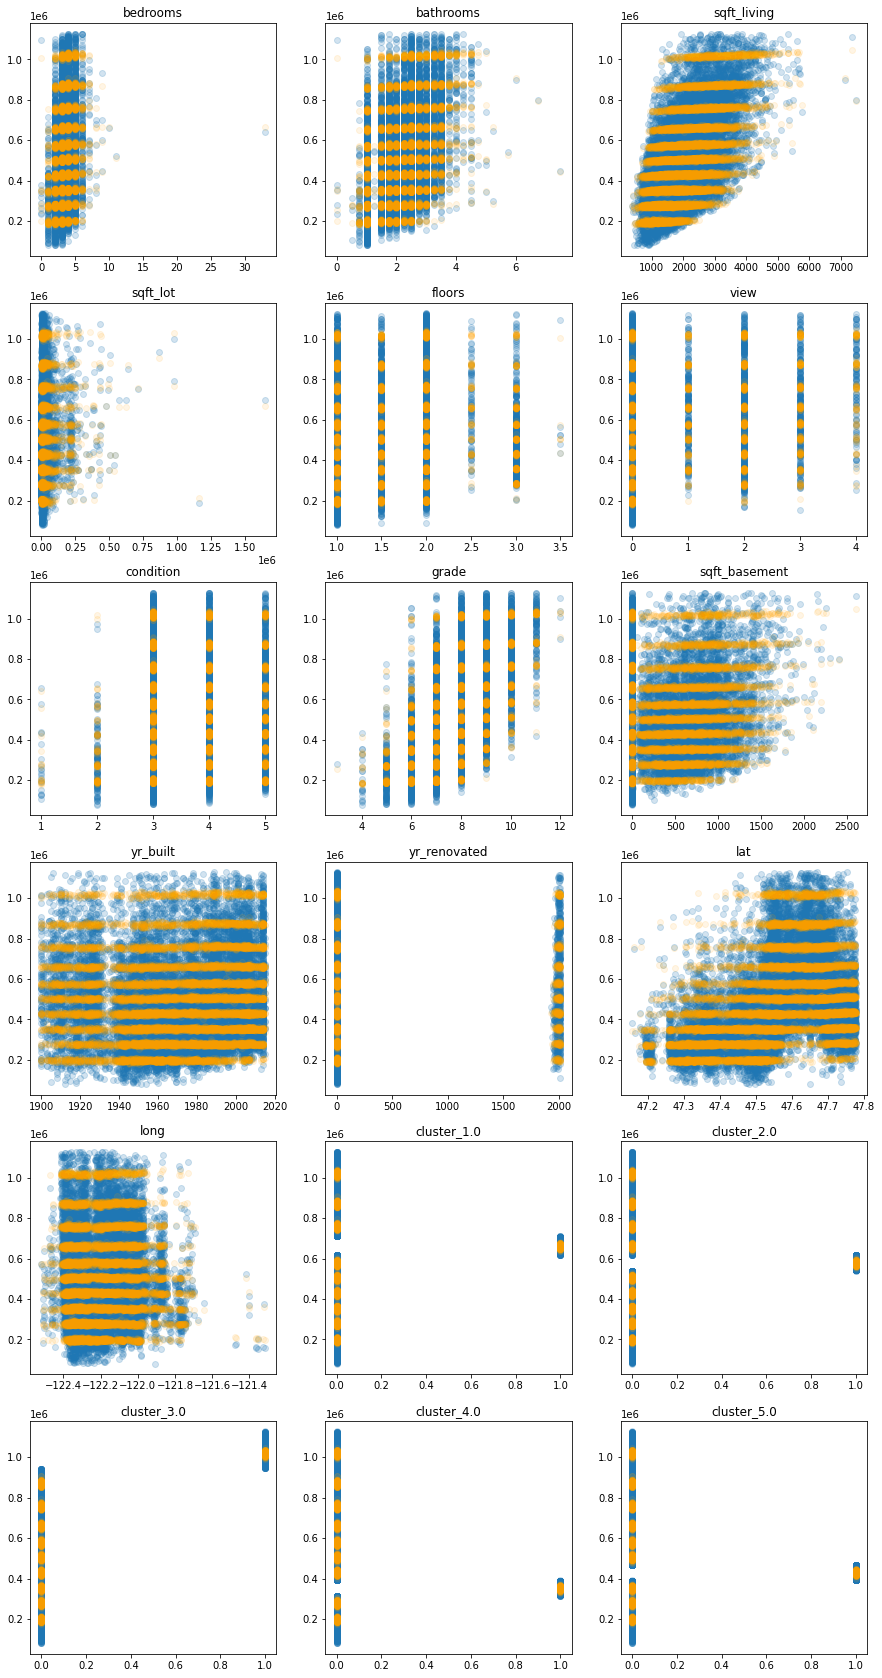

In [38]:
fig, ax = plt.subplots(6, 3, figsize=(15, 30))
m, n = Xn_train.shape
cnt = 0
for ax in ax.flatten():
    try:
        if cnt >= n:
            ax.set_visible(False)
            continue
        newy = model.predict(Xn_train);
        ax.scatter(X_train[:, cnt], y_train, alpha=0.2)
        ax.scatter(X_train[:, cnt], newy, alpha=0.1, c='orange')
        ax.set_title(df.drop('price', axis=1).columns[cnt])
        cnt += 1
    except:
        ax.set_visible(False)
        continue

In [39]:
X_all = df.drop(['price'], axis=1).values
Xn_all = norm(X_all)
p_df = df.copy(deep=True)
p_df['Predicted'] = model.predict(Xn_all).astype('int64')
p_df

bedrooms  bathrooms  sqft_living  sqft_lot  floors  view  \
id                                                                       
7.129301e+09         3       1.00         1180      5650     1.0     0   
6.414100e+09         3       2.25         2570      7242     2.0     0   
5.631500e+09         2       1.00          770     10000     1.0     0   
2.487201e+09         4       3.00         1960      5000     1.0     0   
1.954401e+09         3       2.00         1680      8080     1.0     0   
...                ...        ...          ...       ...     ...   ...   
2.630000e+08         3       2.50         1530      1131     3.0     0   
6.600060e+09         4       2.50         2310      5813     2.0     0   
1.523300e+09         2       0.75         1020      1350     2.0     0   
2.913101e+08         3       2.50         1600      2388     2.0     0   
1.523300e+09         2       0.75         1020      1076     2.0     0   

              condition  grade  sqft_basement  yr_built  ...  cluster_1.0  \
id                                                       ...                
7.129301e+09          3      7              0      1955  ...            0   
6.414100e+09          3      7            400      1951  ...            0   
5.631500e+09          3      6              0      1933  ...            0   
2.487201e+09          5      7            910      1965  ...            0   
1.954401e+09          3      8              0      1987  ...            0   
...                 ...    ...            ...       ...  ...          ...   
2.630000e+08          3      8              0      2009  ...            0   
6.600060e+09          3      8              0      2014  ...            0   
1.523300e+09          3      7              0      2009  ...            0   
2.913101e+08          3      8              0      2004  ...            0   
1.523300e+09          3      7              0      2008  ...            0   

              cluster_2.0  cluster_3.0  cluster_4.0  cluster_5.0  cluster_6.0  \
id                                                                              
7.129301e+09            0            0            0            0            0   
6.414100e+09            0            0            0            0            0   
5.631500e+09            0            0            0            0            0   
2.487201e+09            1            0            0            0            0   
1.954401e+09            0            0            0            0            0   
...                   ...          ...          ...          ...          ...   
2.630000e+08            0            0            1            0            0   
6.600060e+09            0            0            0            1            0   
1.523300e+09            0            0            0            1            0   
2.913101e+08            0            0            0            1            0   
1.523300e+09            0            0            1            0            0   

              cluster_7.0  cluster_8.0  cluster_9.0  Predicted  
id                                                              
7.129301e+09            0            1            0     199921  
6.414100e+09            0            0            0     509655  
5.631500e+09            0            1            0     201915  
2.487201e+09            0            0            0     573654  
1.954401e+09            0            0            0     500677  
...                   ...          ...          ...        ...  
2.630000e+08            0            0            0     360095  
6.600060e+09            0            0            0     428730  
1.523300e+09            0            0            0     419635  
2.913101e+08            0            0            0     427238  
1.523300e+09            0            0            0     346389  

[20297 rows x 24 columns]

In [40]:
model.coef_

array([ 3.03753147e+02,  1.03858191e+03,  2.64204658e+03,  6.33967007e+02,
        9.94314037e+02,  1.02598784e+03,  1.35045422e+03,  4.33894279e+03,
        6.05484403e+02, -1.43528543e+03,  4.93019126e+02,  4.20134326e+03,
        5.44568850e+01,  4.17009346e+04,  2.08575755e+04,  8.79356083e+04,
       -5.32522184e+04, -2.56106207e+04,  6.33216936e+04, -7.89222074e+04,
       -8.39931343e+04,  7.82478404e+04])

In [41]:
model.intercept_

array([477586.97303113])

In [42]:
centeroids

array([[ 4.76152447e+01, -1.22206690e+02,  5.03714999e+05],
       [ 4.76213542e+01, -1.22201022e+02,  6.60373193e+05],
       [ 4.76151207e+01, -1.22208065e+02,  5.76740093e+05],
       [ 4.76174581e+01, -1.22215019e+02,  1.01796959e+06],
       [ 4.75343388e+01, -1.22218856e+02,  3.52609415e+05],
       [ 4.76008047e+01, -1.22218290e+02,  4.28626376e+05],
       [ 4.76185047e+01, -1.22186274e+02,  7.58020669e+05],
       [ 4.74511331e+01, -1.22220358e+02,  2.77490028e+05],
       [ 4.74142630e+01, -1.22235429e+02,  1.96769369e+05],
       [ 4.76244488e+01, -1.22195004e+02,  8.71409893e+05]])

In [43]:
p_df.to_csv('output_LR.csv', index=True)

In [44]:
import joblib

In [45]:
joblib.dump((model.coef_, model.intercept_, centeroids, norm.adapt_mean.numpy(),
             norm.adapt_variance.numpy()), 'trained_data.data')

['trained_data.data']

In [46]:
norm.adapt_variance.numpy()

array([8.4075373e-01, 5.0970042e-01, 6.0108294e+05, 1.6355278e+09,
       2.8904837e-01, 4.0446389e-01, 4.1606784e-01, 1.0774678e+00,
       1.6795812e+05, 8.4903088e+02, 1.4624064e+05, 1.9961158e-02,
       2.0245653e-02, 7.4944384e-02, 8.6696848e-02, 3.0884685e-02,
       1.3369003e-01, 1.2526749e-01, 6.5862373e-02, 1.3347994e-01,
       8.2891904e-02, 4.8062235e-02], dtype=float32)